In [101]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, measure
import matplotlib.patches as patches

In [102]:
target_dir = '../../PLOTS/Shell_algorithm'

In [103]:
path_mean_image = r'D:\Octopus_OdorTracking\DATA\1T\trajectories\khorne\mean_frames_khorne.png'
mean_frames = cv2.imread(path_mean_image, cv2.IMREAD_GRAYSCALE)

threshold: 28
mask shape: (600, 600)
labels shape: (600, 600)
props shape: 1
minr: 249, minc: 269, maxr: 340, maxc: 331
box: [[249, 269], [249, 300.0], [249, 331], [294.5, 269], [294.5, 331], [340, 269], [340, 300.0], [340, 331]]
radius: 59.682493245507096


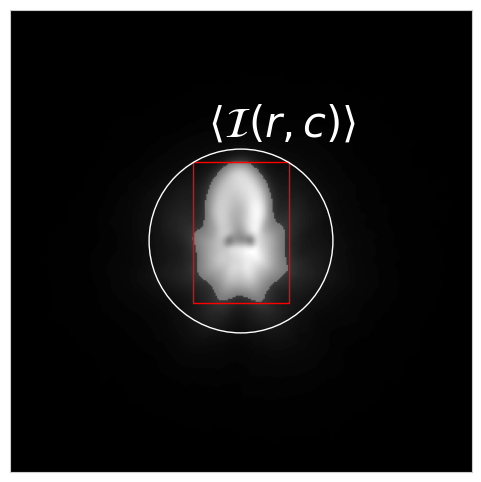

In [104]:
center = (300, 300)
crop_width = 600

fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.imshow(mean_frames, cmap='gray', zorder = 0)

threshold = filters.threshold_otsu(mean_frames)
print(f'threshold: {threshold}')
mask = mean_frames > threshold
print(f'mask shape: {mask.shape}')

ax.imshow(mask, cmap='gray', alpha=0.25, zorder = 1)

labels = measure.label(mask)
print(f'labels shape: {labels.shape}')
props = measure.regionprops(labels)
print(f'props shape: {len(props)}')
minr, minc, maxr, maxc = props[0].bbox
print(f'minr: {minr}, minc: {minc}, maxr: {maxr}, maxc: {maxc}')
rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=1, zorder = 2)
ax.add_patch(rect)
max_dist = 0
box = [[minr, minc], [minr, (maxc+minc)/2], [minr, maxc],
       [(minr+maxr)/2, minc], [(minr+maxr)/2, maxc],
       [maxr, minc], [maxr, (maxc+minc)/2], [maxr, maxc]]
print(f'box: {box}')
box=np.array(box)
for p in box:
  d = ((center[0]-p[0])**2 + (center[1]-p[1])**2)**(1/2)
  if d > max_dist:
    max_dist = d
r = max_dist
print(f'radius: {r}')
circ = patches.Circle(center, radius=r, color='white', fill=False, linewidth=1, zorder = 2)

## add text to the top right of the image
ax.text(0.75, 0.8, r"$\langle \mathcal{I}(r, c) \rangle$", transform=ax.transAxes, fontsize=30, fontweight='bold', va='top', ha='right',
        color='white', zorder=3)

ax.add_patch(circ)

ax.set_xlim(150, 450)
ax.set_ylim(450, 150)

ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

## extract the plot as a numpy array
fig.canvas.draw()
data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

plt.show(fig)
plt.close(fig)

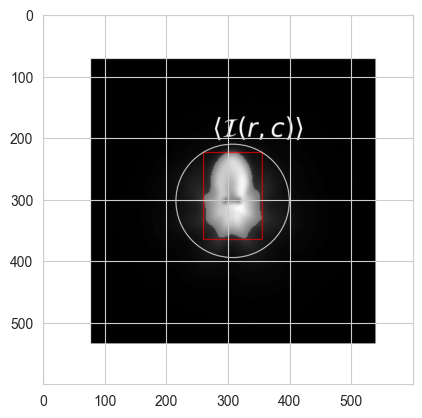

In [105]:
plt.imshow(data)

In [106]:
path_video = r'D:\Octopus_OdorTracking\DATA\1T\trajectories\khorne\Food_eaten\2\rotated_bg_sub_fc_video.mp4'
frame_range = [5683, 5848]

In [107]:
frames = []
cap = cv2.VideoCapture(path_video)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_range[0])
for i in range(frame_range[1]-frame_range[0]):
    ret, frame = cap.read()
    frames.append(frame)
cap.release()


In [108]:
frames = np.array(frames)
frames.shape

(165, 600, 600, 3)

In [109]:
## grab 4 frames evenly spaced
frames_ss = frames[::int(len(frames)/4)]
frames_ss = list(reversed(frames_ss))

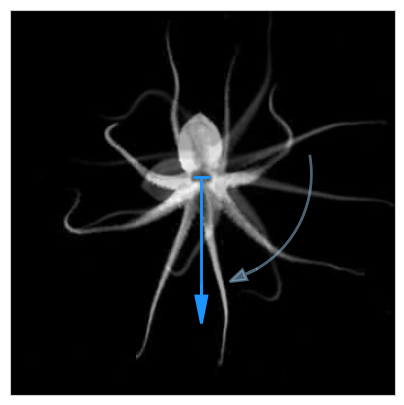

In [110]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

frame = frames_ss[3]
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

ax.imshow(frame, cmap='gray', zorder=0,
          vmin=0, vmax=np.mean(frame)+9*np.std(frame))

line_color = '#1C95FF'
arc_color = '#99C4E2'

arc_alpha=0.5

center = 299
xoffset = 0
yoffset = 3

linewidth = 2

## draw line point from center down
ax.plot([center-xoffset, center-xoffset], [center + yoffset, 400], color=line_color, linewidth=linewidth, zorder=3)
## add arrow to end of line same width as line
ax.arrow(center-xoffset, 400, 0, 10, color=line_color, linewidth=linewidth, head_width=10, head_length=25, zorder=3)

angle = 60
angle1 = -10
rotated_frame = cv2.warpAffine(frame, cv2.getRotationMatrix2D((center,center), 90-angle1, 1), (600, 600))
ax.imshow(rotated_frame, cmap='gray', alpha=0.35, zorder=1)

ax.add_patch(patches.Arc((center, center), 200, 200, theta1=-10, theta2=angle, color=arc_color, linewidth=linewidth, zorder=3,
                         alpha=arc_alpha),)
## draw an arrow which points along the arc to show the rotation of the image

angle = np.deg2rad(angle)  # End of the arc
r = 100  # Half of the arc's width/height
end_x = center + r * np.cos(angle)
end_y = center + r * np.sin(angle)

# Direction of tangent at endpoint (perpendicular to radius at that point)
tangent_dx = -np.sin(angle)-.2
tangent_dy = np.cos(angle)

arrow_length = 10  # Adjust as needed

# Calculate starting and ending points for the arrow
start_x = end_x
start_y = end_y
arrow_end_x = start_x + arrow_length * tangent_dx
arrow_end_y = start_y + arrow_length * tangent_dy

ax.arrow(start_x, start_y, arrow_end_x - start_x, arrow_end_y - start_y,
        color=arc_color, linewidth=linewidth, head_width=10, head_length=15, zorder=3, alpha=arc_alpha)

## draw line that is normal to start of line
length = 14/2
ax.plot([center-length, center+length], [center + yoffset, center + yoffset], color=line_color, linewidth=linewidth, zorder=3)

ax.grid('white')

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlim(125, 475)
ax.set_ylim(500, 150)

name_fig = 'rotated_bg_sub_octopus.png'
path_fig = os.path.join(target_dir, name_fig)
plt.savefig(path_fig, dpi=300, bbox_inches='tight')

plt.show(fig)
plt.close(fig)

In [111]:

def hex_to_rgb(hex_color: str) -> tuple:
    """
    Convert a hex color string to an RGB tuple.
    :param hex_color: Hex color string.
    :return: RGB tuple.
    """
    hex_color = hex_color.lstrip('#')
    lv = len(hex_color)
    return tuple(int(hex_color[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def color_image_edge(img: np.ndarray, color_hex: str, edge_width: int) -> np.ndarray:
    """
    Recolor the edge of an image with the specified color and width.
    :param img: Image array.
    :param color_hex: Hex color code.
    :param edge_width: Width of the edge to be colored.
    :return: Image with colored edges.
    """
    # Ensure that the input image is writable
    img = np.copy(img)

    # Convert hex color to RGB
    color_rgb = hex_to_rgb(color_hex)

    # Color the top edge
    img[:edge_width, :] = color_rgb

    # Color the bottom edge
    img[-edge_width:, :] = color_rgb

    # Color the left edge
    img[:, :edge_width] = color_rgb

    # Color the right edge
    img[:, -edge_width:] = color_rgb

    return img


In [112]:
## crop frames_ss to be 300x300 around the center
center = 300
frames_ss = [frame[center-150:center+150, center-150:center+150] for frame in frames_ss]

edge_color = "#55A4DC"
edge_width = 5
## recolor the edges of the frames
frames_ss = [color_image_edge(frame, edge_color, edge_width) for frame in frames_ss]

edge_width = 10
edge_color = "#D6336E"
frames_ss = frames_ss + [color_image_edge(data[center-150:center+150, center-150:center+150], edge_color, edge_width)]

In [113]:
## calculate std of frames
std = np.std(frames)
## calculate mean of frames
mean = np.mean(frames)

In [114]:
import numpy as np
from mayavi import mlab

def rgb2gray(rgb):
    """Convert RGB image to grayscale."""
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def hex_to_rgb(hex_code):
    """Convert HEX color code to RGB tuple."""
    hex_code = hex_code.lstrip('#')
    return tuple(int(hex_code[i:i+2], 16) / 255.0 for i in (0, 2, 4))

def rescale_image(img):
    """Rescale image intensities to the full 0-255 range."""
    img_min = img.min()
    img_max = img.max()
    return 255.0 * (img - img_min) / (img_max - img_min)

def draw_border(image, z_offset, color="#FFFFFF", border_thickness=5):
    """Draw a border around the image."""
    width, height = image.shape[1], image.shape[0]
    x = [0, width, width, 0, 0]
    y = [0, 0, height, height, 0]
    z = [z_offset] * 5
    rgb_color = hex_to_rgb(color)
    mlab.plot3d(x, y, z, color=rgb_color, tube_radius=border_thickness, tube_sides=1000)

def print_camera_params(scene):
    """Print the current camera parameters."""
    cam = scene.camera
    print("Camera Position:", cam.position)
    print("Focal Point:", cam.focal_point)
    print("View Up:", cam.view_up)
    azimuth, elevation, distance, _ = mlab.view()
    print("Azimuth:", azimuth)
    print("Elevation:", elevation)
    print("Distance:", distance)
    print()

def display_images_in_3d(images, azimuth=0, elevation=0, distance=None, focal_point=None, view_up=None, opacity=1.0,
                         border_thickness=5, width_thickness_final_value=10, arrow_color="#0000FF",
                         border_color="#FFFFFF", final_image_color="#FF0000", final_image_z_offset=400):
    fig = mlab.figure(bgcolor=(1, 1, 1), size=(1600,1000))

    # Enable depth peeling
    fig.scene.render_window.alpha_bit_planes = 1
    fig.scene.renderer.use_depth_peeling = 1
    fig.scene.renderer.maximum_number_of_peels = 500
    fig.scene.renderer.occlusion_ratio = 0.1

    # Attach the callback to print camera parameters
    fig.scene.interactor.add_observer("ModifiedEvent", lambda obj, evt: print_camera_params(fig.scene))

    active_border_color = border_color
    border_width = border_thickness

    z_offset = 0
    for i, image in enumerate(images):
        if len(image.shape) == 3 and image.shape[2] == 3:
            image = rgb2gray(image)
        image = rescale_image(image)

        image_plane = mlab.imshow(image, colormap='gray', vmin=0, vmax=255,
                                  extent=[0, image.shape[1], 0, image.shape[0], z_offset, z_offset])
        image_plane.actor.property.opacity = opacity

        #draw_border(image, z_offset, active_border_color, border_width)

        is_last_image = i == len(images) - 2

        if is_last_image:
            active_border_color = final_image_color
            border_width = width_thickness_final_value
            z_offset -= final_image_z_offset
        else:
            z_offset -= image.shape[0]/2.5

    center_x = images[0].shape[1] / 2.0
    center_y = images[0].shape[0] / 2.0
    starting_z = 200
    arrow_rgb = hex_to_rgb(arrow_color)
    arrow = mlab.quiver3d(center_x, center_y, starting_z, 0, 0, -1,
                      mode='arrow', scale_factor=starting_z-25, color=arrow_rgb)
    arrow_surface = mlab.pipeline.surface(arrow)

    if distance and focal_point:
        mlab.view(azimuth, elevation, distance, focal_point)
    else:
        mlab.view(azimuth, elevation)

    if view_up:
        fig.scene.camera.view_up = view_up
        fig.scene.reset_zoom()

    mlab.show()

# Sample values for camera parameters
azimuth_value = 108.71132894908091
elevation_value = 37.77921348722882
distance_value = 3307.6746201806095
focal_point_value = (149.26776695,  149.26776695, -342.49506682)  # Sample values, adjust as needed
view_up_value = (-0.97974746, -0.08467771, -0.18145137)  # Typically points to "up" direction

# Sample values for image parameters
image_opacity = 1.0
border_thickness_value = 3

# Display images
color_before = "#55A4DC"
color_end = "#D6336E"
width_thickness_final_value = 5

# Note: Before calling the below function, ensure frames_ss is initialized.
display_images_in_3d(frames_ss, azimuth_value, elevation_value, distance_value, focal_point_value, view_up_value,
                     image_opacity, border_thickness_value, width_thickness_final_value,
                     arrow_color=color_before, border_color=color_before, final_image_color=color_end)


Camera Position: [-290.54165096 1450.67733037 1431.72084239]
Focal Point: [ 150.  150. -340.]
View Up: [-0.97974746 -0.08467771 -0.18145137]
Azimuth: 108.71132894908091
Elevation: 37.77921348722883
Distance: 2241.613973749882

Camera Position: [-290.54165096 1450.67733037 1431.72084239]
Focal Point: [ 150.  150. -340.]
View Up: [-0.97974746 -0.08467771 -0.18145137]
Azimuth: 108.71132894908091
Elevation: 37.77921348722883
Distance: 2241.613973749882

Camera Position: [-290.54165096 1450.67733037 1431.72084239]
Focal Point: [ 150.  150. -340.]
View Up: [-0.97974746 -0.08467771 -0.18145137]
Azimuth: 108.71132894908091
Elevation: 37.77921348722883
Distance: 2241.613973749882

Camera Position: [-290.54165096 1450.67733037 1431.72084239]
Focal Point: [ 150.  150. -340.]
View Up: [-0.97974746 -0.08467771 -0.18145137]
Azimuth: 108.71132894908091
Elevation: 37.77921348722883
Distance: 2241.613973749882

Camera Position: [-290.54165096 1450.67733037 1431.72084239]
Focal Point: [ 150.  150. -340.